In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
from scipy import stats

In [2]:
df_exam_score = pd.read_csv("/home/hatice/Desktop/DS_UniVR/first_year/programmingAndDB/programming_final_project/Expanded_data_with_more_features.csv")

In [3]:
# better visualization of numbers
pd.options.display.float_format = '{:,.2f}'.format 

# FUNCTIONS

In [4]:
# def transform_string_to_numerical(my_df):
#     """
#     Transform string variables in the DataFrame to numerical representation using LabelEncoder.
#     Preserve NaN values as NaN.

#     Parameters:
#     - my_df: pandas DataFrame containing string variables

#     Returns:
#     - transformed_df: DataFrame with string variables transformed into numerical representation
#     """
#     transformed_df = my_df.copy()  # Create a copy of the original DataFrame

#     for column in transformed_df.columns:
#         if transformed_df[column].dtype == 'object':  # Check if the column contains string variables
#             label_encoder = LabelEncoder()

#             # Filter out NaN values and fit the LabelEncoder
#             label_encoder.fit(transformed_df[column].dropna().unique())

#             # Transform the column, preserving NaN values
#             transformed_df[column] = transformed_df[column].apply(
#                 lambda x: label_encoder.transform([x])[0] if pd.notnull(x) else np.nan
#             )

#     return transformed_df


In [5]:
# # filling missing values with most common ones
# def fillna_with_group_mode(series): 
#     mode_value = series.mode().iat[0] if not series.mode().empty else np.nan
#     return series.fillna(mode_value)

# # Apply the function to each column
# df_exam_score_transformed = df_exam_score_transformed.apply(lambda col: fillna_with_group_mode(col) if col.name in list_of_columns else col)

In [6]:
# the function provides a quick way to control the unique values in each column of a DataFrame
def print_unique_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"Unique values in column '{column}': {unique_values}")

In [99]:
# Creating function two impute restant categories (in our case: EthnicGroup, ParentMaritalStatus)

def impute_missing_values_with_random_forest(df, column_name):
    # Select only numerical columns (excluding the target column)
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if column_name in numerical_columns:
        numerical_columns.remove(column_name)

    # Exclude columns with NaN values
    numerical_columns = [col for col in numerical_columns if not df[col].isna().any()]

    # Splitting the data into two parts: one where target column is missing and one where it's not
    df_with_target = df[df[column_name].notna()] #the target column is not NaN: These rows provide 
                        # valuable information because they contain actual data that the model can learn from
    df_without_target = df[df[column_name].isna()] #rows where the target column is NaN and needs to be imputed 
                                # (using the information from the rows where the target column is not empty.)

    # Prepare the features (X) and target (y) using only numerical columns
    x = df_with_target[numerical_columns]
    y = df_with_target[column_name]

    # Create and train the model
    model = RandomForestClassifier(random_state=42)
    model.fit(x, y)

    # Predicting the missing values
    predicted_values = model.predict(df_without_target[numerical_columns])

    # Fill in the missing values in the original DataFrame
    df.loc[df[column_name].isna(), column_name] = predicted_values
    return df

# DATA EXPLORATION AND DATA WRANGLING

##  Dataset exploration

In [8]:
df_exam_score.head()

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.00,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.00,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.00,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.00,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.00,school_bus,5 - 10,76,78,75


In [9]:
df_exam_score.drop('Unnamed: 0',axis=1, inplace=True)

In [10]:
df_exam_score.T

,0,1,2,3,4,5,6,7,8,9,...,30631,30632,30633,30634,30635,30636,30637,30638,30639,30640
Gender,female,female,female,male,male,female,female,male,male,female,...,male,female,female,male,male,female,male,female,female,male
EthnicGroup,NaN,group C,group B,group A,group C,group B,group B,group B,group D,group B,...,group E,group D,group C,group A,group C,group D,group E,NaN,group D,group B
ParentEduc,bachelor's degree,some college,master's degree,associate's degree,some college,associate's degree,some college,some college,high school,high school,...,some high school,some college,master's degree,associate's degree,some college,high school,high school,high school,associate's degree,some college
LunchType,standard,standard,standard,free/reduced,standard,standard,standard,free/reduced,free/reduced,free/reduced,...,standard,standard,standard,free/reduced,standard,standard,standard,free/reduced,standard,standard
TestPrep,none,NaN,none,none,none,none,completed,none,completed,none,...,none,none,completed,completed,none,none,none,completed,completed,none
ParentMaritalStatus,married,married,single,married,married,married,widowed,married,single,married,...,married,married,married,NaN,married,single,single,married,married,married
PracticeSport,regularly,sometimes,sometimes,never,sometimes,regularly,never,sometimes,sometimes,regularly,...,sometimes,regularly,never,sometimes,regularly,sometimes,regularly,sometimes,regularly,never
IsFirstChild,yes,yes,yes,no,yes,yes,no,yes,no,yes,...,no,no,no,no,no,no,no,no,no,no
NrSiblings,3.00,0.00,4.00,1.00,0.00,1.00,1.00,1.00,3.00,NaN,...,3.00,3.00,2.00,2.00,2.00,2.00,1.00,1.00,3.00,1.00
TransportMeans,school_bus,NaN,school_bus,NaN,school_bus,school_bus,private,private,private,private,...,school_bus,private,school_bus,school_bus,school_bus,school_bus,private,private,school_bus,school_bus


In [11]:
df_exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 3.3+ MB


In [12]:
df_exam_score.describe().T

,count,mean,std,min,25%,50%,75%,max
NrSiblings,"29,069.00",2.15,1.46,0.00,1.00,2.00,3.00,7.00
MathScore,"30,641.00",66.56,15.36,0.00,56.00,67.00,78.00,100.00
ReadingScore,"30,641.00",69.38,14.76,10.00,59.00,70.00,80.00,100.00
WritingScore,"30,641.00",68.42,15.44,4.00,58.00,69.00,79.00,100.00


In [13]:
df_exam_score_copy = df_exam_score.copy()

In [14]:
print_unique_values(df_exam_score_copy[['EthnicGroup','ParentEduc','Gender','LunchType','TestPrep','ParentMaritalStatus','PracticeSport','IsFirstChild','NrSiblings','TransportMeans','WklyStudyHours']])

Unique values in column 'EthnicGroup': [nan 'group C' 'group B' 'group A' 'group D' 'group E']
Unique values in column 'ParentEduc': ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school' nan]
Unique values in column 'Gender': ['female' 'male']
Unique values in column 'LunchType': ['standard' 'free/reduced']
Unique values in column 'TestPrep': ['none' nan 'completed']
Unique values in column 'ParentMaritalStatus': ['married' 'single' 'widowed' nan 'divorced']
Unique values in column 'PracticeSport': ['regularly' 'sometimes' 'never' nan]
Unique values in column 'IsFirstChild': ['yes' 'no' nan]
Unique values in column 'NrSiblings': [ 3.  0.  4.  1. nan  2.  5.  7.  6.]
Unique values in column 'TransportMeans': ['school_bus' nan 'private']
Unique values in column 'WklyStudyHours': ['< 5' '5 - 10' '> 10' nan]


In [15]:
# Correcting the syntax to replace values based on conditions
df_exam_score_copy.loc[df_exam_score_copy['ParentEduc'] == 'some high school', 'ParentEduc'] = 'high school'
df_exam_score_copy.loc[df_exam_score_copy['ParentEduc'] == 'some college', 'ParentEduc'] = "bachelor's degree"

In [16]:
df_exam_score_copy['ParentEduc'].unique()

array(["bachelor's degree", "master's degree", "associate's degree",
       'high school', nan], dtype=object)

**Numerical encoding for each variable for correlation**
- EthnicGroup: One-hot encoding: Each ethnic group has a different binary variable.
- ParentEduc: Numerical encoding from 0 to 3 for different education levels (0 is lower and 3 is higher).
- Gender: Binary encoding: 1 for female, 0 for male.
- LunchType: Binary encoding: 0 for standard, 1 for free/reduced.
- TestPrep: Binary encoding: 1 for completed course, 0 for none.
- PracticeSport: Numerical encoding: 0 for never, 1 for sometimes, 2 for regularly.
- IsFirstChild: Binary encoding: 1 for yes, 0 for no.
- TransportMeans: Binary encoding: 0 for schoolbus, 1 for private transport.
- WklyStudyHours: Numerical encoding: 0 for <5 hours, 1 for 5-10 hours, 2 for >10 hours.


In [17]:
replace_parentEduc={
    'high school':0,
    "bachelor's degree":1,
    "master's degree":2,
    "associate's degree":3
}

df_exam_score_copy['ParentEduc'].replace(replace_parentEduc,inplace=True)

In [18]:
replace_gender={
    'male':0,
    "female":1
}

df_exam_score_copy['Gender'].replace(replace_gender,inplace=True)

In [19]:
replace_LunchType={
    'standard':0,
    "free/reduced":1
}

df_exam_score_copy['LunchType'].replace(replace_LunchType,inplace=True)

In [20]:
replace_TestPrep={
    'none':0,
    "completed":1
}

df_exam_score_copy['TestPrep'].replace(replace_TestPrep,inplace=True)

In [21]:
replace_PracticeSport={
    'never':0,
    "sometimes":1,
    "regularly":2
}

df_exam_score_copy['PracticeSport'].replace(replace_PracticeSport,inplace=True)

In [22]:
replace_IsFirstChild={
    'no':0,
    "yes":1
}

df_exam_score_copy['IsFirstChild'].replace(replace_IsFirstChild,inplace=True)

In [23]:
replace_TransportMeans={
    'school_bus':0,
    "private":1
}

df_exam_score_copy['TransportMeans'].replace(replace_TransportMeans,inplace=True)

In [24]:
replace_WklyStudyHours={
    '< 5' :0,
    '5 - 10':1,
    '> 10':2
}

df_exam_score_copy['WklyStudyHours'].replace(replace_WklyStudyHours,inplace=True)

In [25]:
print_unique_values(df_exam_score_copy[['EthnicGroup','ParentEduc','Gender','LunchType','TestPrep','ParentMaritalStatus','PracticeSport','IsFirstChild','NrSiblings','TransportMeans','WklyStudyHours']])

Unique values in column 'EthnicGroup': [nan 'group C' 'group B' 'group A' 'group D' 'group E']
Unique values in column 'ParentEduc': [ 1.  2.  3.  0. nan]
Unique values in column 'Gender': [1 0]
Unique values in column 'LunchType': [0 1]
Unique values in column 'TestPrep': [ 0. nan  1.]
Unique values in column 'ParentMaritalStatus': ['married' 'single' 'widowed' nan 'divorced']
Unique values in column 'PracticeSport': [ 2.  1.  0. nan]
Unique values in column 'IsFirstChild': [ 1.  0. nan]
Unique values in column 'NrSiblings': [ 3.  0.  4.  1. nan  2.  5.  7.  6.]
Unique values in column 'TransportMeans': [ 0. nan  1.]
Unique values in column 'WklyStudyHours': [ 0.  1.  2. nan]


In [26]:
df_exam_score_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  int64  
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  float64
 3   LunchType            30641 non-null  int64  
 4   TestPrep             28811 non-null  float64
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  float64
 7   IsFirstChild         29737 non-null  float64
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  float64
 10  WklyStudyHours       29686 non-null  float64
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(7), int64(5), object(2)
memory usage: 3.3+ MB


In [27]:
for column in df_exam_score_copy.columns:
    if df_exam_score_copy[column].isna().any():
        df_exam_score_copy = impute_missing_values_with_random_forest(df_exam_score_copy, column)

In [28]:
df_exam_score_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  int64  
 1   EthnicGroup          30641 non-null  object 
 2   ParentEduc           30641 non-null  float64
 3   LunchType            30641 non-null  int64  
 4   TestPrep             30641 non-null  float64
 5   ParentMaritalStatus  30641 non-null  object 
 6   PracticeSport        30641 non-null  float64
 7   IsFirstChild         30641 non-null  float64
 8   NrSiblings           30641 non-null  float64
 9   TransportMeans       30641 non-null  float64
 10  WklyStudyHours       30641 non-null  float64
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(7), int64(5), object(2)
memory usage: 3.3+ MB


In [29]:
df_exam_score_copy['EthnicGroup'].unique()

array(['group D', 'group C', 'group B', 'group A', 'group E'],
      dtype=object)

In [30]:
# Applying one-hot encoding to the specified features
df_exam_score_copy = pd.get_dummies(df_exam_score_copy, columns=['EthnicGroup', 'ParentMaritalStatus'], dummy_na=True)

df_exam_score_copy.head().T

,0,1,2,3,4
Gender,1.00,1.00,1.00,0.00,0.00
ParentEduc,1.00,1.00,2.00,3.00,1.00
LunchType,0.00,0.00,0.00,1.00,0.00
TestPrep,0.00,1.00,0.00,0.00,0.00
PracticeSport,2.00,1.00,1.00,0.00,1.00
IsFirstChild,1.00,1.00,1.00,0.00,1.00
NrSiblings,3.00,0.00,4.00,1.00,0.00
TransportMeans,0.00,0.00,0.00,0.00,0.00
WklyStudyHours,0.00,1.00,0.00,1.00,1.00
MathScore,71.00,69.00,87.00,45.00,76.00


In [31]:
df_exam_score_copy.drop('EthnicGroup_nan', axis=1, inplace=True)
df_exam_score_copy.drop('ParentMaritalStatus_nan', axis=1, inplace=True)


In [32]:
df_exam_score_copy.head().T

,0,1,2,3,4
Gender,1.00,1.00,1.00,0.00,0.00
ParentEduc,1.00,1.00,2.00,3.00,1.00
LunchType,0.00,0.00,0.00,1.00,0.00
TestPrep,0.00,1.00,0.00,0.00,0.00
PracticeSport,2.00,1.00,1.00,0.00,1.00
IsFirstChild,1.00,1.00,1.00,0.00,1.00
NrSiblings,3.00,0.00,4.00,1.00,0.00
TransportMeans,0.00,0.00,0.00,0.00,0.00
WklyStudyHours,0.00,1.00,0.00,1.00,1.00
MathScore,71.00,69.00,87.00,45.00,76.00


### Correlation:
I transformed string values into numerical in order to have a new dataframe that I can use to see all correations.
<br> Deleted the first column because it was used  as index but we don't needed as we use pandas dataframe 

In [33]:
df_exam_score_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        30641 non-null  int64  
 1   ParentEduc                    30641 non-null  float64
 2   LunchType                     30641 non-null  int64  
 3   TestPrep                      30641 non-null  float64
 4   PracticeSport                 30641 non-null  float64
 5   IsFirstChild                  30641 non-null  float64
 6   NrSiblings                    30641 non-null  float64
 7   TransportMeans                30641 non-null  float64
 8   WklyStudyHours                30641 non-null  float64
 9   MathScore                     30641 non-null  int64  
 10  ReadingScore                  30641 non-null  int64  
 11  WritingScore                  30641 non-null  int64  
 12  EthnicGroup_group A           30641 non-null  uint8  
 13  E

In [34]:
df_exam_score_copy.WklyStudyHours.unique()

array([0., 1., 2.])

In [35]:
df_exam_score_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,"30,641.00",0.50,0.50,0.00,0.00,1.00,1.00,1.00
ParentEduc,"30,641.00",1.06,1.10,0.00,0.00,1.00,2.00,3.00
LunchType,"30,641.00",0.35,0.48,0.00,0.00,0.00,1.00,1.00
TestPrep,"30,641.00",0.34,0.47,0.00,0.00,0.00,1.00,1.00
PracticeSport,"30,641.00",1.23,0.66,0.00,1.00,1.00,2.00,2.00
IsFirstChild,"30,641.00",0.65,0.48,0.00,0.00,1.00,1.00,1.00
NrSiblings,"30,641.00",2.13,1.45,0.00,1.00,2.00,3.00,7.00
TransportMeans,"30,641.00",0.40,0.49,0.00,0.00,0.00,1.00,1.00
WklyStudyHours,"30,641.00",0.90,0.66,0.00,0.00,1.00,1.00,2.00
MathScore,"30,641.00",66.56,15.36,0.00,56.00,67.00,78.00,100.00


In [36]:
df_exam_score_corr = df_exam_score_copy.corr()

In [37]:
df_exam_score_corr

,Gender,ParentEduc,LunchType,TestPrep,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,...,WritingScore,EthnicGroup_group A,EthnicGroup_group B,EthnicGroup_group C,EthnicGroup_group D,EthnicGroup_group E,ParentMaritalStatus_divorced,ParentMaritalStatus_married,ParentMaritalStatus_single,ParentMaritalStatus_widowed
Gender,1.00,-0.00,-0.00,0.01,0.00,-0.01,0.00,0.01,0.00,-0.16,...,0.29,0.00,0.00,-0.01,-0.00,0.00,0.02,-0.02,0.01,-0.01
ParentEduc,-0.00,1.00,0.01,0.01,0.00,-0.00,-0.00,-0.00,0.00,0.14,...,0.17,-0.01,-0.00,-0.00,0.01,0.00,-0.01,0.00,0.01,-0.00
LunchType,-0.00,0.01,1.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.37,...,-0.27,-0.01,0.01,-0.00,-0.00,0.00,-0.00,-0.01,0.01,0.01
TestPrep,0.01,0.01,0.00,1.00,-0.00,-0.00,-0.01,0.01,-0.00,0.14,...,0.30,-0.01,0.01,-0.00,0.01,-0.01,0.00,-0.00,-0.00,-0.00
PracticeSport,0.00,0.00,0.00,-0.00,1.00,0.01,-0.01,-0.01,-0.00,0.08,...,0.07,-0.00,-0.01,0.00,-0.00,0.01,0.00,0.00,-0.00,-0.01
IsFirstChild,-0.01,-0.00,-0.00,-0.00,0.01,1.00,-0.12,0.00,-0.00,0.02,...,0.01,-0.01,0.01,-0.01,0.00,0.00,0.00,0.01,-0.01,0.01
NrSiblings,0.00,-0.00,-0.00,-0.01,-0.01,-0.12,1.00,0.01,0.00,-0.00,...,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.01,-0.00,-0.00,-0.00
TransportMeans,0.01,-0.00,-0.00,0.01,-0.01,0.00,0.01,1.00,0.01,-0.01,...,0.00,0.01,-0.00,0.01,-0.01,-0.01,-0.01,0.01,-0.00,-0.00
WklyStudyHours,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.01,1.00,0.09,...,0.06,0.01,-0.01,-0.01,0.01,0.01,-0.00,0.00,0.00,-0.00
MathScore,-0.16,0.14,-0.37,0.14,0.08,0.02,-0.00,-0.01,0.09,1.00,...,0.81,-0.07,-0.10,-0.08,0.04,0.23,0.00,0.01,-0.01,0.01


<AxesSubplot:>

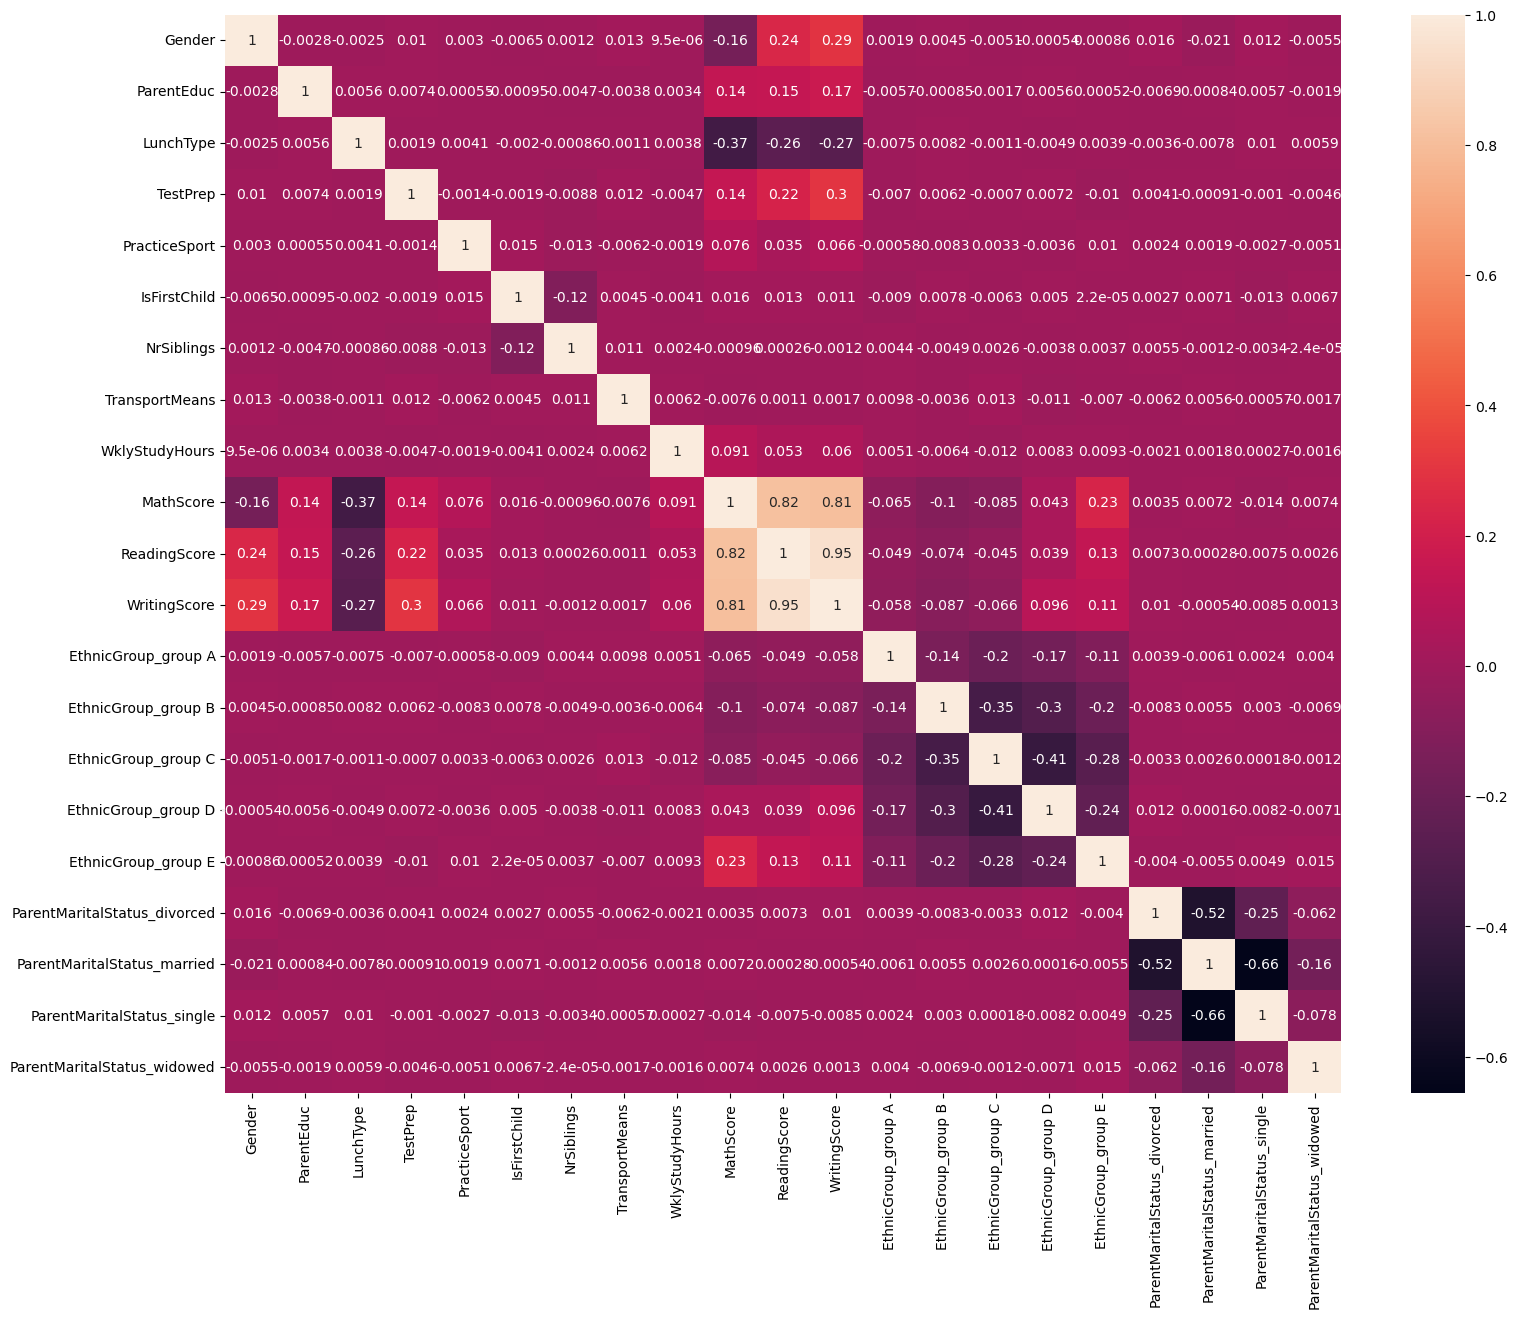

In [38]:
plt.figure(figsize=(18, 14))
sb.heatmap(df_exam_score_corr, annot=True)

In [39]:
# add a column called GradePointAvarage and fill it with average of grade point of the student
# df_exam_score_transformed["GradePointAvarage"] = (df_exam_score_transformed["MathScore"] + df_exam_score_transformed["ReadingScore"] + df_exam_score_transformed["WritingScore"] ) / 3
# df_exam_score_transformed.T

In [40]:
# MathScoreAvarage = df_exam_score_transformed["MathScore"].mean()
# ReadingScoreAvarage = df_exam_score_transformed["ReadingScore"].mean()
# WritingScoreAvarage = df_exam_score_transformed["WritingScore"].mean()

In [41]:
# df_exam_score_transformed.hist(figsize=(14, 12), bins = 10)
# plt.show()

## Plots

In [42]:
#bar_plot = [["math", "reading", "writing"], [MathScoreAvarage, ReadingScoreAvarage, WritingScoreAvarage]]

In [43]:
#plt.figure(figsize=(10, 6))
#bars = plt.bar(bar_plot[0], bar_plot[1])
#plt.xlabel = ('Subjects')
#plt.ylabel(" Avarage Scores")
#plt.show()

In [44]:
#df_exam_score.plot(title="DataFrame plot")

# MODEL

In [57]:
import seaborn as sns

In [49]:
df_exam_score_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        30641 non-null  int64  
 1   ParentEduc                    30641 non-null  float64
 2   LunchType                     30641 non-null  int64  
 3   TestPrep                      30641 non-null  float64
 4   PracticeSport                 30641 non-null  float64
 5   IsFirstChild                  30641 non-null  float64
 6   NrSiblings                    30641 non-null  float64
 7   TransportMeans                30641 non-null  float64
 8   WklyStudyHours                30641 non-null  float64
 9   MathScore                     30641 non-null  int64  
 10  ReadingScore                  30641 non-null  int64  
 11  WritingScore                  30641 non-null  int64  
 12  EthnicGroup_group A           30641 non-null  uint8  
 13  E

plotting to see if there are any outliers

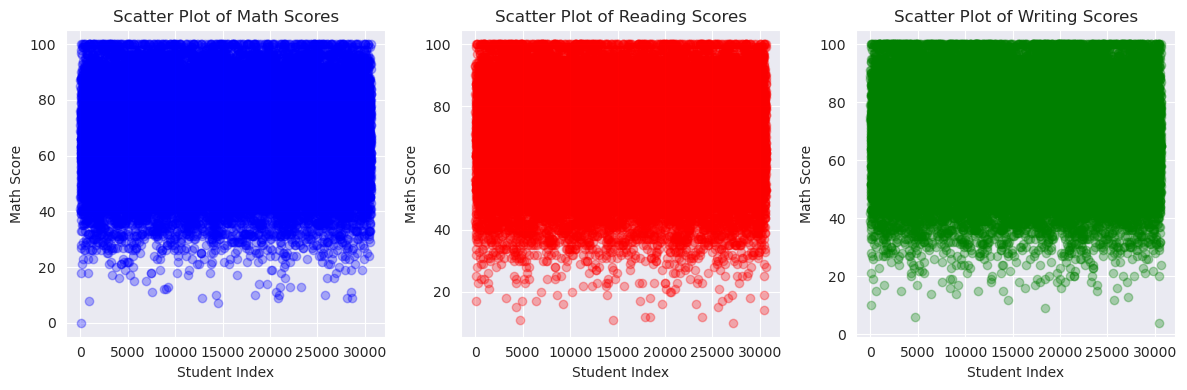

In [95]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(df_exam_score_copy.index, df_exam_score_copy['MathScore'], color='blue', alpha=0.3) 
plt.title('Scatter Plot of Math Scores')  
plt.xlabel('Student Index')
plt.ylabel('Math Score')

plt.subplot(1, 3, 2)
plt.scatter(df_exam_score_copy.index, df_exam_score_copy['ReadingScore'], color='red', alpha=0.3) 
plt.title('Scatter Plot of Reading Scores')  
plt.xlabel('Student Index')
plt.ylabel('Math Score')

plt.subplot(1, 3, 3)
plt.scatter(df_exam_score_copy.index, df_exam_score_copy['WritingScore'], color='green', alpha=0.3) 
plt.title('Scatter Plot of Writing Scores')  
plt.xlabel('Student Index')
plt.ylabel('Math Score')

plt.tight_layout()
plt.show()


another way to visualize the score distributions and see if there are any outilers

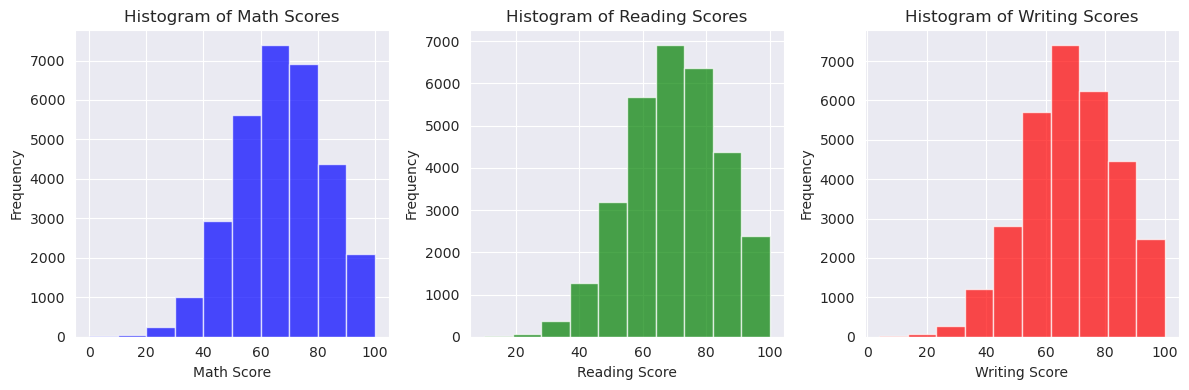

In [98]:
plt.figure(figsize=(12, 4))

# MathScore histogram
plt.subplot(1, 3, 1)
plt.hist(df_exam_score_copy['MathScore'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Math Score')
plt.ylabel('Frequency')
plt.title('Histogram of Math Scores')

# ReadingScore histogram
plt.subplot(1, 3, 2)
plt.hist(df_exam_score_copy['ReadingScore'], bins=10, color='green', alpha=0.7)
plt.xlabel('Reading Score')
plt.ylabel('Frequency')
plt.title('Histogram of Reading Scores')

# WritingScore histogram
plt.subplot(1, 3, 3)
plt.hist(df_exam_score_copy['WritingScore'], bins=10, color='red', alpha=0.7)
plt.xlabel('Writing Score')
plt.ylabel('Frequency')
plt.title('Histogram of Writing Scores')

plt.tight_layout()
plt.show()


visualizing outliers using boxplot, which visualize distributions 

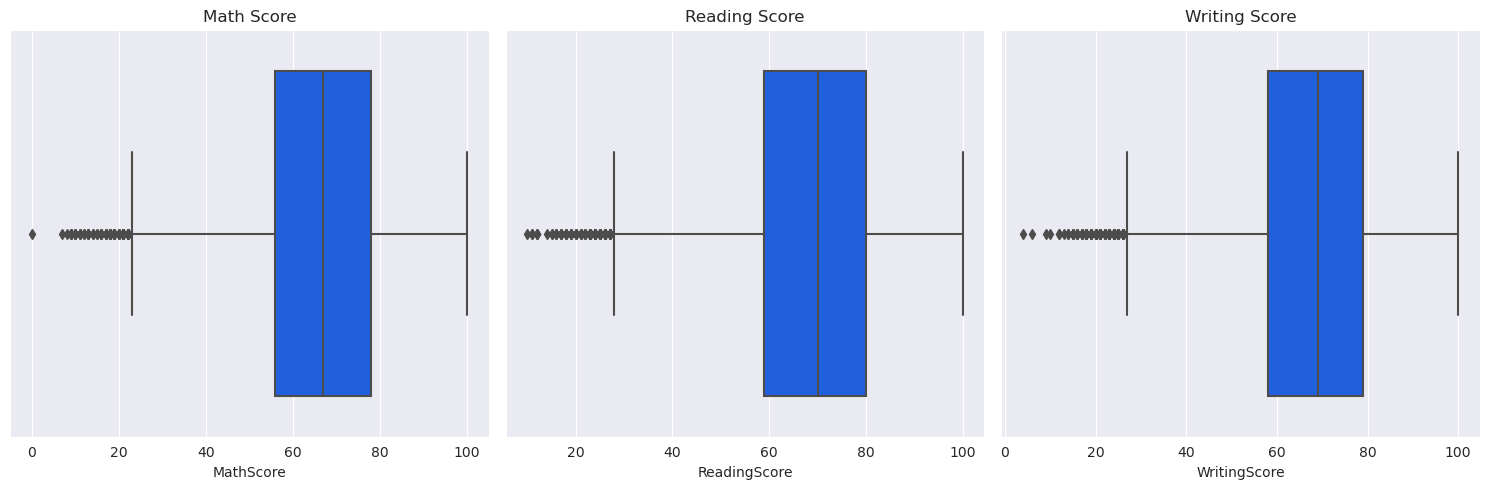

In [81]:
# Create a figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot MathScore boxplot
sns.boxplot(x=df_exam_score_copy['MathScore'], ax=axs[0])
axs[0].set_title('Math Score')

# Plot ReadingScore boxplot
sns.boxplot(x=df_exam_score_copy['ReadingScore'], ax=axs[1])
axs[1].set_title('Reading Score')

# Plot WritingScore boxplot
sns.boxplot(x=df_exam_score_copy['WritingScore'], ax=axs[2])
axs[2].set_title('Writing Score')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Detect outliers using z-score which is used to figure out how far each score is from the avarage score. 
<br> treshold=3 because it corresponds to approximately 99.7% of the data falling within ±3 standard deviations from the mean in a normal distribution.
<br>The numpy.where() function returns the indices of elements in an input array where the given condition is satisfied, in this case it returns zscores > 3 which are the outliers.

In [79]:
z_scores = np.abs(stats.zscore(df_exam_score_copy[['MathScore', 'ReadingScore', 'WritingScore']]))
threshold = 3
outliers = np.where(z_scores > threshold)

# Print the indices of outliers
print("Indices of outliers:", outliers)

Indices of outliers: (array([   17,    55,    55,    55,    69,    69,   308,   308,   565,
         565,   751,   928,   928,  1344,  1484,  1484,  3197,  3197,
        3283,  3738,  4052,  4083,  4232,  4232,  4245,  4245,  4260,
        4719,  4719,  4719,  4886,  4886,  5174,  5174,  5263,  5263,
        5445,  5513,  5641,  5641,  5703,  6408,  6408,  6892,  6892,
        7423,  7440,  7553,  7553,  7553,  8373,  8373,  8428,  8439,
        8459,  8559,  8559,  8785,  9046,  9046,  9046,  9268,  9268,
        9268, 10164, 10164, 10164, 11333, 11333, 11333, 11446, 12346,
       12731, 12748, 12789, 12789, 12789, 13621, 13821, 13821, 13822,
       13846, 13933, 13933, 13980, 14274, 14494, 14494, 14494, 14708,
       14708, 15653, 15653, 16326, 16480, 17238, 17399, 17399, 17540,
       17540, 17924, 17924, 18385, 18385, 18385, 18432, 18432, 18862,
       18862, 18862, 19630, 19630, 19688, 19688, 19998, 20009, 20009,
       20127, 20127, 20127, 20249, 20554, 20554, 20603, 20603, 20860

**OUTLIERS CLEANING:** not sure to do this, because they are not "problematic" values or incorrectly entered in our dataset. So, we'll see if keep the new df or not

In [83]:
# Remove outliers
df_exam_score_without_outliers = df_exam_score_copy[(z_scores < threshold).all(axis=1)]


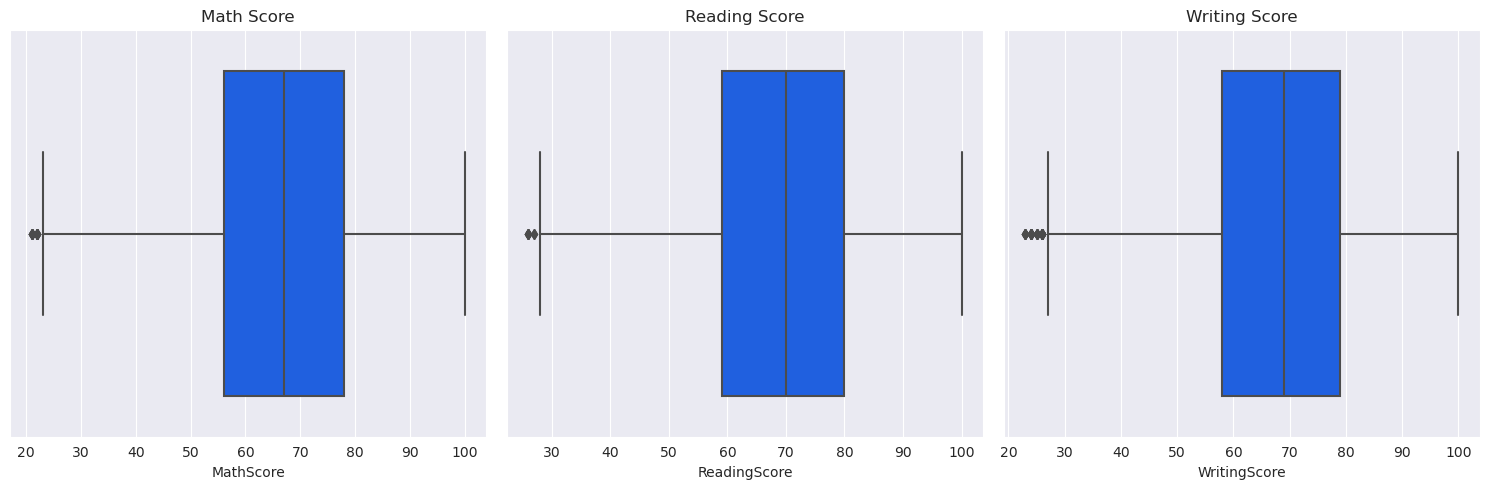

In [84]:
# Create a figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot MathScore boxplot
sns.boxplot(x=df_exam_score_without_outliers['MathScore'], ax=axs[0])
axs[0].set_title('Math Score')

# Plot ReadingScore boxplot
sns.boxplot(x=df_exam_score_without_outliers['ReadingScore'], ax=axs[1])
axs[1].set_title('Reading Score')

# Plot WritingScore boxplot
sns.boxplot(x=df_exam_score_without_outliers['WritingScore'], ax=axs[2])
axs[2].set_title('Writing Score')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## BUILDING MODEL

as i don't want to work for each subject separetely i will create a new column called GradePointAvarage which is contain average of grade point of each student and i'll work on that

In [104]:
df_exam_score_copy["GradePointAvarage"] =(df_exam_score_copy["MathScore"] + df_exam_score_copy["ReadingScore"] + df_exam_score_copy["WritingScore"] ) / 3
df_exam_score_copy.T

,0,1,2,3,4,5,6,7,8,9,...,30631,30632,30633,30634,30635,30636,30637,30638,30639,30640
Gender,1.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00
ParentEduc,1.00,1.00,2.00,3.00,1.00,3.00,1.00,1.00,0.00,0.00,...,0.00,1.00,2.00,3.00,1.00,0.00,0.00,0.00,3.00,1.00
LunchType,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
TestPrep,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
PracticeSport,2.00,1.00,1.00,0.00,1.00,2.00,0.00,1.00,1.00,2.00,...,1.00,2.00,0.00,1.00,2.00,1.00,2.00,1.00,2.00,0.00
IsFirstChild,1.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NrSiblings,3.00,0.00,4.00,1.00,0.00,1.00,1.00,1.00,3.00,2.00,...,3.00,3.00,2.00,2.00,2.00,2.00,1.00,1.00,3.00,1.00
TransportMeans,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
WklyStudyHours,0.00,1.00,0.00,1.00,1.00,1.00,1.00,2.00,2.00,0.00,...,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
MathScore,71.00,69.00,87.00,45.00,76.00,73.00,85.00,41.00,65.00,37.00,...,80.00,82.00,84.00,65.00,58.00,59.00,58.00,61.00,82.00,64.00


In [159]:
X = df_exam_score_copy.drop('GradePointAvarage', axis=1)
y=df_exam_score_copy['GradePointAvarage']

In [160]:
#split dataset by taking 80% of data for training and 20% of data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train model

In [161]:
# X_train = X_train.values.reshape(-1, 1)
# X_train

In [162]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [163]:
# y_pred = model.predict(X_test.values.reshape(-1, 1))

In [164]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

new_model = model_evaluation(model, X_test, y_test, 'Linear Reg.')


visualization

In [165]:
# Create a dataframe with actual and predicted values
y_test_pred = model.predict(X_test)
df_comp = pd.DataFrame({'Actual':y_test, 'Predicted':y_test_pred})

In [166]:
def show_plot(y_train, model):
    size = len(y_train)
    x = np.arange(size)
    plt.scatter(x, y_train)
    plt.plot(x, model, 'red')
    # plt.xticks(x[::3])
    plt.show()

In [175]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Scatterplot of actual vs. predicted values
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_test_pred)
# plt.xlabel('Actual Grade Point Average')
# plt.ylabel('Predicted Grade Point Average')
# plt.title('Actual vs. Predicted Grade Point Average')
# plt.show()

# # Residual plot
# residuals = y_test - y_test_pred
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test_pred, residuals)
# plt.axhline(y=0, color='red', linestyle='--')
# plt.xlabel('Predicted Grade Point Average')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.show()

# # Distribution of residuals
# plt.figure(figsize=(8, 6))
# sns.histplot(residuals, kde=True)
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.title('Distribution of Residuals')
# plt.show()

# # Coefficients plot
# plt.figure(figsize=(10, 6))
# coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
# sns.barplot(x='Coefficient', y='Feature', data=coef_df)
# plt.xlabel('Coefficient')
# plt.ylabel('Feature')
# plt.title('Model Coefficients')
# plt.show()


two way to visualize, we see that we have a overfitting: may be i need to clean outliers? 



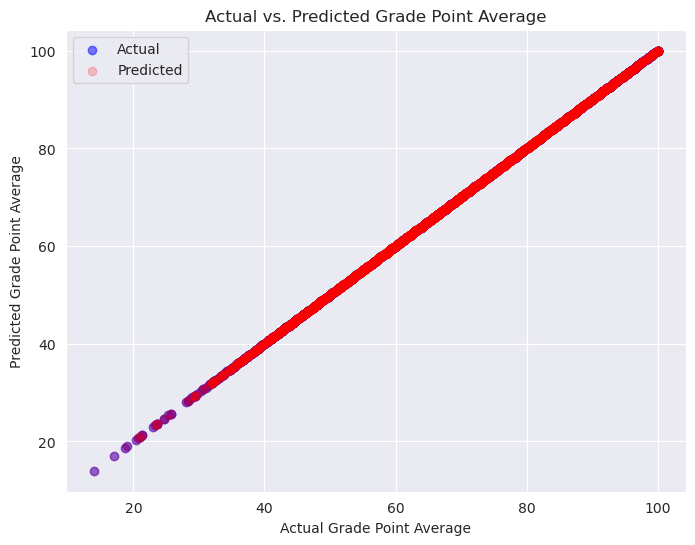

In [176]:
import matplotlib.pyplot as plt

# Scatterplot of actual vs. predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.5)  # Plot actual values
plt.scatter(y_test, y_test_pred, color='red', label='Predicted', alpha=0.2)  # Plot predicted values
plt.xlabel('Actual Grade Point Average')
plt.ylabel('Predicted Grade Point Average')
plt.title('Actual vs. Predicted Grade Point Average')
plt.legend()
plt.show()


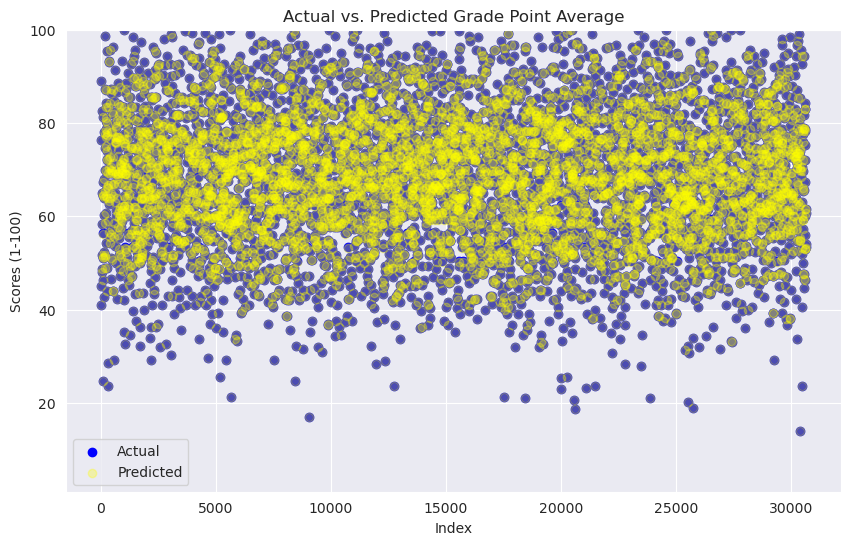

In [174]:
import matplotlib.pyplot as plt

# Scatterplot of actual vs. predicted values with different colors
plt.figure(figsize=(10, 6))

# Plot actual values
plt.scatter(y_test.index, y_test, color='blue', label='Actual', alpha=1)

# Plot predicted values
plt.scatter(y_test.index, y_test_pred, color='yellow', label='Predicted', alpha=0.3)

plt.xlabel('Index')
plt.ylabel('Scores (1-100)')
plt.title('Actual vs. Predicted Grade Point Average')
plt.ylim(1, 100)  # Set y-axis limits from 1 to 100
plt.legend()
plt.show()


In [154]:
# plt.scatter(X_train, y_train)
# plt.scatter(X_test, y_test, c='red')
# full_model = model_evaluation(model, X_test, y_test, 'Linear Reg.')
# plt.plot(full_model)

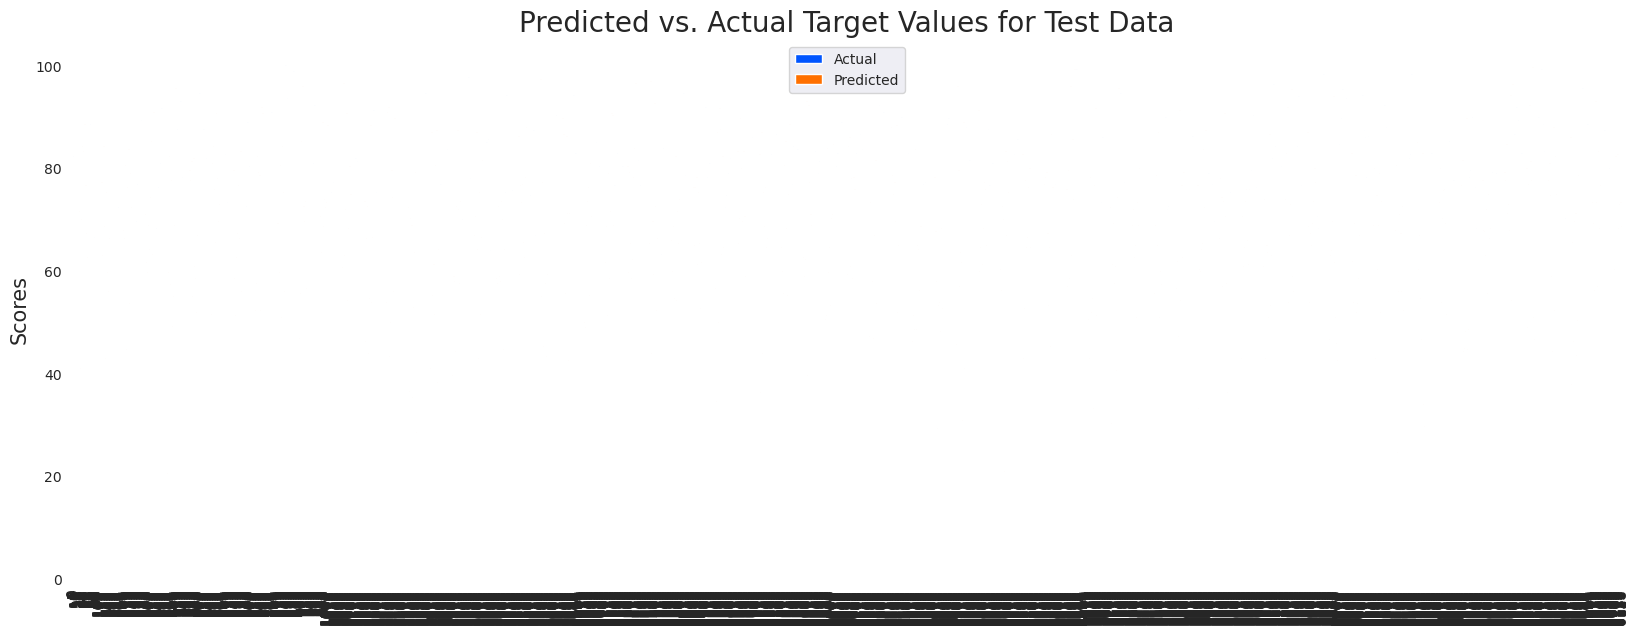

In [152]:
def compare_plot(df_comp):
    df_comp.reset_index(inplace=True)
    df_comp.plot(y=['Actual','Predicted'], kind='bar', figsize=(20,7), width=0.8)
    plt.title('Predicted vs. Actual Target Values for Test Data', fontsize=20)
    plt.ylabel('Scores', fontsize=15)
    plt.show()

compare_plot(df_comp)